# 태풍 솔릭(Soulik) 모의를 위한 ROMS 영역의<br/>HYCOM I.C 자료 가져오기 by NetcdfSubset

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
from datetime import datetime
from urllib import parse, request
from multiprocessing import Process

#import numpy as np
from netCDF4 import Dataset, num2date, date2num

## 1. 정보 설정

In [2]:
# 실험명
expname = 'Soulik'; version = 'v4'

# 초기장 날짜 설정
#date_init = datetime(2018,8,18,12) # year, month, day, hour
date_init = datetime(2018,8,21,0) # year, month, day, hour
ymdh_init = date_init.strftime('%Y-%m-%dT%H:%M:%SZ')

server = 'https://ncss.hycom.org/thredds/ncss'
version = 'GLBv0.08'; expt = 'expt_93.0'
server = '/'.join([server,version,expt])

strideTime  = 1 # time resolution. ex) every 3hours * 1 = 3hours
#strideVert  = 2 # vertical resolution. ex) 40level / 2 = 20level
strideHoriz = 1 # horizontal resolution. ex) 1/12deg * 2 = 1/6deg
extraHoriz  = 1.0 # in degrees. use 2 times of delta X or delta Y.

# ROMS 격자 정보 가져오기
roms_grid_fname = '../Grid/'+expname+'_grd_'+version+'.nc'
if not os.path.isfile(roms_grid_fname):
    print("==>Error: not found - %s"%roms_grid_fname)
else:
    with Dataset(roms_grid_fname) as roms_grid:
        minmaxLonR = [round(roms_grid['lon_vert'][:].min()-extraHoriz,3), # west
                      round(roms_grid['lon_vert'][:].max()+extraHoriz,3)] # east
        minmaxLatR = [round(roms_grid['lat_vert'][:].min()-extraHoriz,3), # south
                      round(roms_grid['lat_vert'][:].max()+extraHoriz,3)] # north
        print('==>Info: ', minmaxLonR, minmaxLatR)
        
# 기본 url 생성
#https://ncss.hycom.org/thredds/ncss/GLBv0.08/expt_93.0
#       ?var=surf_el&var=salinity&var=water_temp&var=water_u&var=water_v
#       &north=53&west=116&east=161&south=19
#       &disableProjSubset=on&horizStride=6
#       &time_start=2018-08-18T12%3A00%3A00Z&time_end=2018-08-24T12%3A00%3A00Z&timeStride=1
#       &vertCoord=&addLatLon=true&accept=netcdf4
query = [('north',minmaxLatR[1]),('west',minmaxLonR[0]),('east',minmaxLonR[1]),('south',minmaxLatR[0]), # NWES
         ('disableProjSubset','on'),('horizStride',strideHoriz),
         ('vertCoord',''),('addLatLon','true'),('accept','netcdf4'),
         ('time_start',ymdh_init),('time_end',ymdh_init),('timeStride',strideTime)] # time start, end, stride

params = parse.urlencode(query, encoding='UTF-8', doseq=True)
urls = {'ts3z': "%s/ts3z?%s&var=water_temp&var=salinity"%(server,params),
        'uv3z': "%s/uv3z?%s&var=water_u&var=water_v"%(server,params),
        'ssh' : "%s/ssh?%s&var=surf_el"%(server,params)}; print(urls)

==>Info:  [97.279, 191.521] [4.162, 62.558]
{'ts3z': 'https://ncss.hycom.org/thredds/ncss/GLBv0.08/expt_93.0/ts3z?north=62.558&west=97.279&east=191.521&south=4.162&disableProjSubset=on&horizStride=1&vertCoord=&addLatLon=true&accept=netcdf4&time_start=2018-08-21T00%3A00%3A00Z&time_end=2018-08-21T00%3A00%3A00Z&timeStride=1&var=water_temp&var=salinity', 'uv3z': 'https://ncss.hycom.org/thredds/ncss/GLBv0.08/expt_93.0/uv3z?north=62.558&west=97.279&east=191.521&south=4.162&disableProjSubset=on&horizStride=1&vertCoord=&addLatLon=true&accept=netcdf4&time_start=2018-08-21T00%3A00%3A00Z&time_end=2018-08-21T00%3A00%3A00Z&timeStride=1&var=water_u&var=water_v', 'ssh': 'https://ncss.hycom.org/thredds/ncss/GLBv0.08/expt_93.0/ssh?north=62.558&west=97.279&east=191.521&south=4.162&disableProjSubset=on&horizStride=1&vertCoord=&addLatLon=true&accept=netcdf4&time_start=2018-08-21T00%3A00%3A00Z&time_end=2018-08-21T00%3A00%3A00Z&timeStride=1&var=surf_el'}


## 2. HYCOM으로 부터 수온, 염분, U, V, SSH 자료 가져오기 

In [3]:
# Note) HYCOM 자료는 서버와의 반응이 느리면 (보통 5분 제한) 끊기는 현상이 발생하므로 
#       시간 단위로 받은 후 합치는 방법을 사용할 것을 추천함

# 자료 저장 범용 함수 정의
def getHYCOM(prefix, tinfo, vnames, clobber=False):
    outfile = 'HYCOM4%s_%s_%s.nc4'%(expname,prefix,tinfo)
    if os.path.isfile(outfile):
        if clobber: os.remove(outfile)
        else: print('==>Info: already exists %s'%outfile); return

    url = "%s&%s"%(urls[prefix],tinfo)
    print('==>Info[%s]: %s to %s'%(prefix,url,outfile))
    _=request.urlretrieve(url, outfile)
    
    # Note) HYCOM의 기본 _FillValue(-30000s)를 pyroms에서 인식하지 못하기 때문에 nc를 unpacking하여 NaN으로 바꾸어 줌.
    #for v in vnames:
    #    os.system('ncpdq -O -P upk %s %s'%(outfile,outfile))
    #    #os.system('ncatted -a _FillValue,%s,o,d,NaN %s'%(v,outfile))
    #    #os.system('ncatted -a missing_value,%s,o,d,NaN %s'%(v,outfile))
        
pTS = Process(target=getHYCOM, args=('ts3z',ymdh_init,['water_temp','salinity'])); pTS.start() # temp, salt
pUV = Process(target=getHYCOM, args=('uv3z',ymdh_init,['water_u','water_v'])); pUV.start() # u, v
pSSH= Process(target=getHYCOM, args=('ssh',ymdh_init,['surf_el'])); pSSH.start()# ssh
pTS.join(); pUV.join(); pSSH.join() 

==>Info[ts3z]: https://ncss.hycom.org/thredds/ncss/GLBv0.08/expt_93.0/ts3z?north=62.558&west=97.279&east=191.521&south=4.162&disableProjSubset=on&horizStride=1&vertCoord=&addLatLon=true&accept=netcdf4&time_start=2018-08-21T00%3A00%3A00Z&time_end=2018-08-21T00%3A00%3A00Z&timeStride=1&var=water_temp&var=salinity&2018-08-21T00:00:00Z to HYCOM4Soulik_ts3z_2018-08-21T00:00:00Z.nc4
==>Info[uv3z]: https://ncss.hycom.org/thredds/ncss/GLBv0.08/expt_93.0/uv3z?north=62.558&west=97.279&east=191.521&south=4.162&disableProjSubset=on&horizStride=1&vertCoord=&addLatLon=true&accept=netcdf4&time_start=2018-08-21T00%3A00%3A00Z&time_end=2018-08-21T00%3A00%3A00Z&timeStride=1&var=water_u&var=water_v&2018-08-21T00:00:00Z to HYCOM4Soulik_uv3z_2018-08-21T00:00:00Z.nc4
==>Info[ssh]: https://ncss.hycom.org/thredds/ncss/GLBv0.08/expt_93.0/ssh?north=62.558&west=97.279&east=191.521&south=4.162&disableProjSubset=on&horizStride=1&vertCoord=&addLatLon=true&accept=netcdf4&time_start=2018-08-21T00%3A00%3A00Z&time_end=20

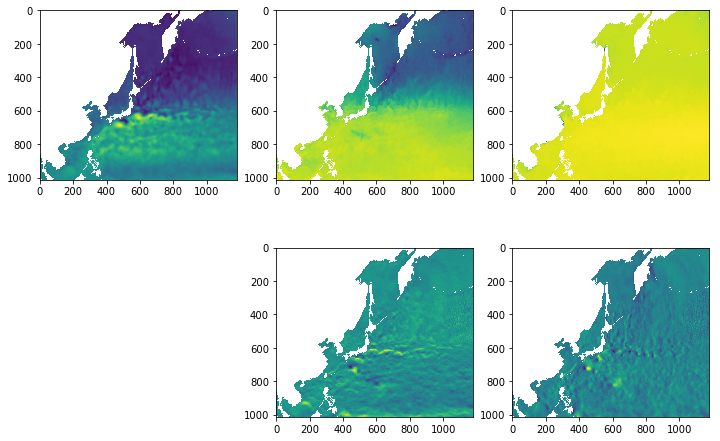

In [4]:
fig = plt.figure(figsize=(12,8))
axE = fig.add_subplot(2,3,1); axT = fig.add_subplot(2,3,2); axS = fig.add_subplot(2,3,3)
axU = fig.add_subplot(2,3,5); axV = fig.add_subplot(2,3,6)

with Dataset('HYCOM4%s_ssh_%s.nc4'%(expname,ymdh_init)) as ncE,\
     Dataset('HYCOM4%s_ts3z_%s.nc4'%(expname,ymdh_init)) as ncTS,\
     Dataset('HYCOM4%s_uv3z_%s.nc4'%(expname,ymdh_init)) as ncUV:
    _=axE.imshow(ncE['surf_el'][0,::-1,:])
    _=axT.imshow(ncTS['water_temp'][0,0,::-1,:])
    _=axS.imshow(ncTS['salinity'][0,0,::-1,:])
    _=axU.imshow(ncUV['water_u'][0,0,::-1,:])
    _=axV.imshow(ncUV['water_v'][0,0,::-1,:])